In [9]:
!pip install biopython nglview reportlab
!nglview enable

/bin/bash: line 1: nglview: command not found


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from contextlib import closing

In [11]:
from Bio import SeqIO, SeqUtils, ExPASy, SwissProt, PDB
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Data import CodonTable
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import gc_fraction
from Bio import AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import MafftCommandline
from Bio.Phylo.Applications import FastTreeCommandline
from reportlab.lib import colors

/usr/local/lib/python3.11/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [12]:
from io import StringIO
import pandas as pd
from collections import OrderedDict

In [13]:
import nglview
from reportlab.lib import colors
import warnings
warnings.filterwarnings("ignore")

In [14]:
import Bio
print("BioPython version:", Bio.__version__)

BioPython version: 1.85


In [15]:
!apt-get install -y mafft fasttree
!pip install biopython pandas scikit-learn matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fasttree is already the newest version (2.1.11-2).
mafft is already the newest version (7.490-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [16]:
### Parse a FASTA file and inspect records
fungi = SeqIO.parse("fungi.ITS.fna", "fasta")
rec1 = next(fungi)
print(rec1)
print("Record type:", type(rec1))

ID: NR_132798.1
Name: NR_132798.1
Description: NR_132798.1 Roccella elisabethae S L14846 ITS region; from TYPE material
Number of features: 0
Seq('GAACCTGCGGAAGGATCATTATTAAGACAGGGCCTGTTAGGCCCGACCTCCAAC...GAA')
Record type: <class 'Bio.SeqRecord.SeqRecord'>


In [17]:
### Use SeqIO.index to access a specific sequence
fungi_index = SeqIO.index("fungi.ITS.fna", "fasta")
print(fungi_index['NR_111007.1'])
print("Total records:", len(fungi_index))

ID: NR_111007.1
Name: NR_111007.1
Description: NR_111007.1 Saccharomyces cerevisiae CBS 1171 ITS region; from TYPE material
Number of features: 0
Seq('AAAGAAATTTAATAATTTTGAAAATGGATTTTTTTGTTTTGGCAAGAGCATGAG...AGT')
Total records: 8906


In [18]:
### Read E. coli genome FASTA and explore sequence
with open("GCF_000005845.2_ASM584v2_genomic.fna") as fp:
    ecoli = SeqIO.read(fp, "fasta")

print("Length:", len(ecoli))
print("Description:", ecoli.description)
print("Sequence type:", type(ecoli.seq))

Length: 4641652
Description: NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
Sequence type: <class 'Bio.Seq.Seq'>


In [19]:
### Slice and analyze the DNA sequence
seq = ecoli.seq
start, stop = 205125, 208608  # dnaE
cds = seq[start:stop]
print("Length of CDS:", len(cds))
print("Protein (standard table):", cds.translate(cds=True))

Length of CDS: 3483
Protein (standard table): MSEPRFVHLRVHSDYSMIDGLAKTAPLVKKAAALGMPALAITDFTNLCGLVKFYGAGHGAGIKPIVGADFNVQCDLLGDELTHLTVLAANNTGYQNLTLLISKAYQRGYGAAGPIIDRDWLIELNEGLILLSGGRMGDVGRSLLRGNSALVDECVAFYEEHFPDRYFLELIRTGRPDEESYLHAAVELAEARGLPVVATNDVRFIDSSDFDAHEIRVAIHDGFTLDDPKRPRNYSPQQYMRSEEEMCELFADIPEALANTVEIAKRCNVTVRLGEYFLPQFPTGDMSTEDYLVKRAKEGLEERLAFLFPDEEERLKRRPEYDERLETELQVINQMGFPGYFLIVMEFIQWSKDNGVPVGPGRGSGAGSLVAYALKITDLDPLEFDLLFERFLNPERVSMPDFDVDFCMEKRDQVIEHVADMYGRDAVSQIITFGTMAAKAVIRDVGRVLGHPYGFVDRISKLIPPDPGMTLAKAFEAEPQLPEIYEADEEVKALIDMARKLEGVTRNAGKHAGGVVIAPTKITDFAPLYCDEEGKHPVTQFDKSDVEYAGLVKFDFLGLRTLTIINWALEMINKRRAKNGEPPLDIAAIPLDDKKSFDMLQRSETTAVFQLESRGMKDLIKRLQPDCFEDMIALVALFRPGPLQSGMVDNFIDRKHGREEISYPDVQWQHESLKPVLEPTYGIILYQEQVMQIAQVLSGYTLGGADMLRRAMGKKKPEEMAKQRSVFAEGAEKNGINAELAMKIFDLVEKFAGYGFNKSHSAAYALVSYQTLWLKAHYPAEFMAAVMTADMDNTEKVVGLVDECWRMGLKILPPDINSGLYHFHVNDDGEIVYGIGAIKGVGEGPIEAIIEARNKGGYFRELFDLCARTDTKKLNRRVLEKLIMSGAFDRLGPHRAALMNSLGDALKAADQHAKAEAIGQADMFGVLAEEPEQIEQSYASCQPWPEQVVLDGER

In [20]:
### Use correct codon table for Bacteria
bact_table = CodonTable.unambiguous_dna_by_name['Bacterial']
protein_bact = cds.translate(table=bact_table, cds=True)
print(bact_table)
print("Protein matches standard translation:", protein_bact == cds.translate(cds=True))

Table 11 Bacterial, Archaeal, Plant Plastid

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA I(s)| ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG

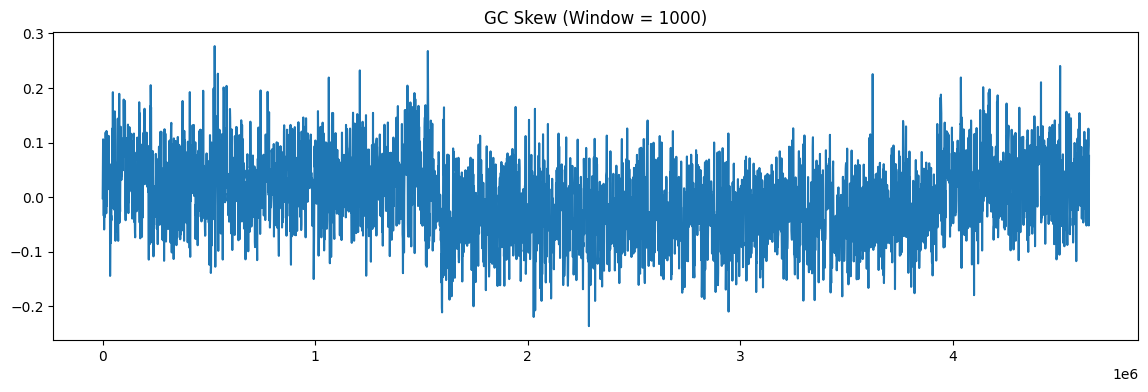

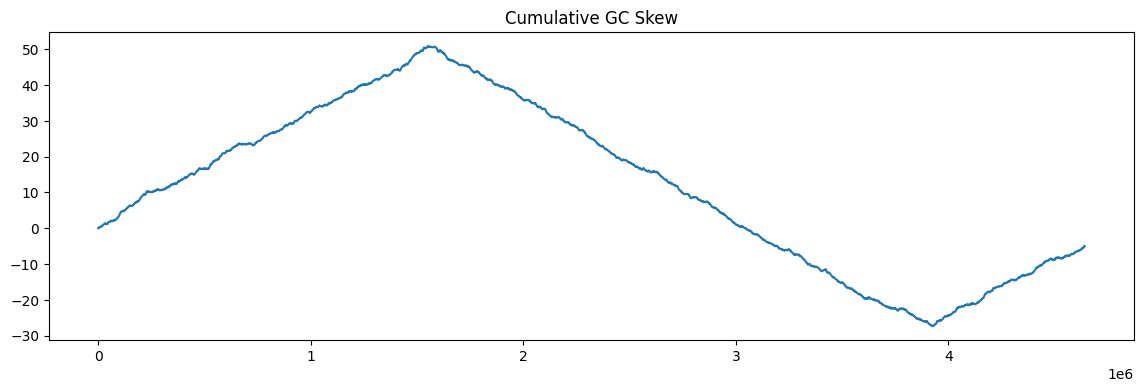

Origin of Replication (approx): 3925000
Terminus (approx): 1551000


In [21]:
### GC skew analysis (sliding window & cumulative)
window = 1000
gc_skew = SeqUtils.GC_skew(seq, window=window)
x_pos = np.arange(0, len(seq), window)

plt.figure(figsize=(14,4))
plt.plot(x_pos, gc_skew)
plt.title("GC Skew (Window = 1000)")
plt.show()

gc_skew_cum = np.cumsum(gc_skew)
plt.figure(figsize=(14,4))
plt.plot(x_pos, gc_skew_cum)
plt.title("Cumulative GC Skew")
plt.show()

ori = np.argmin(gc_skew_cum) * window
ter = np.argmax(gc_skew_cum) * window
print("Origin of Replication (approx):", ori)
print("Terminus (approx):", ter)


In [22]:
!head GCF_000005845.2_ASM584v2_genomic.gbff

LOCUS       NC_000913            4641652 bp    DNA     circular CON 08-AUG-2016
DEFINITION  Escherichia coli str. K-12 substr. MG1655, complete genome.
ACCESSION   NC_000913
VERSION     NC_000913.3
DBLINK      BioProject: PRJNA57779
            BioSample: SAMN02604091
            Assembly: GCF_000005845.2
KEYWORDS    RefSeq.
SOURCE      Escherichia coli str. K-12 substr. MG1655
  ORGANISM  Escherichia coli str. K-12 substr. MG1655


In [23]:
### Genbank parsing and feature exploration
with open("GCF_000005845.2_ASM584v2_genomic.gbff") as fp:
    gbk_record = SeqIO.read(fp, "genbank")

print("Available feature types:", set(f.type for f in gbk_record.features))

Available feature types: {'mobile_element', 'repeat_region', 'tmRNA', 'ncRNA', 'rRNA', 'tRNA', 'gene', 'misc_feature', 'rep_origin', 'source', 'CDS'}


In [24]:
### CDS feature analysis and dnaE location
cds_features = [f for f in gbk_record.features if f.type == "CDS"]
print("Number of CDS features:", len(cds_features))

rep_origin = [f for f in gbk_record.features if f.type == "rep_origin"]
print("Origin of replication feature:", rep_origin)

dnaE_cds = next(f for f in cds_features if f.qualifiers.get("gene", [""])[0] == "dnaE")
print("dnaE CDS location:", dnaE_cds.location)


Number of CDS features: 4319
Origin of replication feature: [SeqFeature(SimpleLocation(ExactPosition(3925743), ExactPosition(3925975), strand=1), type='rep_origin', qualifiers=...)]
dnaE CDS location: [205125:208608](+)


In [25]:
print(dnaE_cds)

type: CDS
location: [205125:208608](+)
qualifiers:
    Key: EC_number, Value: ['2.7.7.7']
    Key: GO_component, Value: ['GO:0005737 - cytoplasm']
    Key: GO_process, Value: ['GO:0006261 - DNA-dependent DNA replication']
    Key: codon_start, Value: ['1']
    Key: db_xref, Value: ['ASAP:ABE-0000624', 'UniProtKB/Swiss-Prot:P10443', 'EcoGene:EG10238', 'GeneID:944877']
    Key: function, Value: ['enzyme; DNA - replication, repair, restriction/modification']
    Key: gene, Value: ['dnaE']
    Key: gene_synonym, Value: ['ECK0183; JW0179; polC; sdgC']
    Key: locus_tag, Value: ['b0184']
    Key: note, Value: ['DNA polymerase III, alpha subunit']
    Key: product, Value: ['DNA polymerase III alpha subunit']
    Key: protein_id, Value: ['NP_414726.1']
    Key: transl_table, Value: ['11']
    Key: translation, Value: ['MSEPRFVHLRVHSDYSMIDGLAKTAPLVKKAAALGMPALAITDFTNLCGLVKFYGAGHGAGIKPIVGADFNVQCDLLGDELTHLTVLAANNTGYQNLTLLISKAYQRGYGAAGPIIDRDWLIELNEGLILLSGGRMGDVGRSLLRGNSALVDECVAFYEEHFPDRYFLELIRTGRP

In [26]:
### Coding percentage of genome
coding_length = sum(len(f) for f in cds_features)
print("Coding percentage: {:.2%}".format(coding_length / len(seq)))

Coding percentage: 88.10%


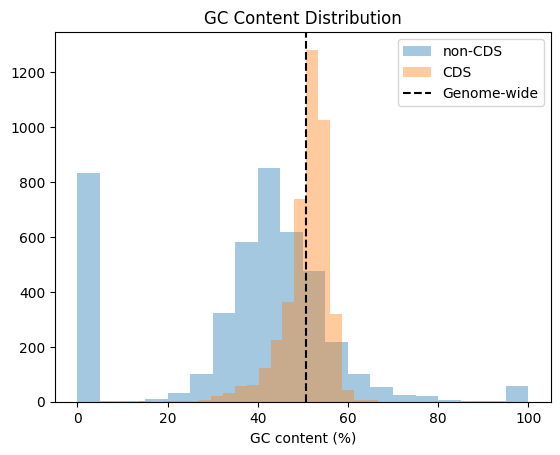

In [27]:
### GC content in CDS vs non-CDS
cds_gc = [gc_fraction(f.extract(seq)) * 100 for f in cds_features]

non_cds_gc = []
for flank0, flank1 in zip(cds_features[:-1], cds_features[1:]):
    s, e = int(flank0.location.end), int(flank1.location.start)
    non_cds_gc.append(gc_fraction(seq[s:e]) * 100)

fig, ax = plt.subplots()
ax.hist(non_cds_gc, bins=20, alpha=0.4, label='non-CDS')
ax.hist(cds_gc, bins=20, alpha=0.4, label='CDS')
ax.axvline(gc_fraction(seq) * 100, color='black', linestyle='dashed', label='Genome-wide')
ax.set_title("GC Content Distribution")
ax.set_xlabel("GC content (%)")
ax.legend()
plt.show()

In [28]:
### Protein metadata from SwissProt
with ExPASy.get_sprot_raw("P10443") as handle:
    prot_record = SwissProt.read(handle)

print("Protein name:", prot_record.entry_name)
print("Organism:", prot_record.organism)
print("Function comment:", prot_record.comments[0])

Protein name: DPO3A_ECOLI
Organism: Escherichia coli (strain K12).
Function comment: FUNCTION: DNA polymerase III is a complex, multichain enzyme responsible for most of the replicative synthesis in bacteria (PubMed:2932432). This DNA polymerase also exhibits 3' to 5' exonuclease activity. The alpha chain is the DNA polymerase catalytic subunit (PubMed:2932432). It is tethered to replicating DNA by the beta sliding clamp (dnaN), which confers extremely high processivity to the catalytic subunit, copying a 5.4 kb genome in 11 seconds, a speed of at least 500 nucleotides/second at 30 degrees Celsius (PubMed:2413035). {ECO:0000269|PubMed:2413035, ECO:0000269|PubMed:2932432}.


In [29]:
### Load and visualize PDB with NGLView
pdb_refs = [ref[1] for ref in prot_record.cross_references if ref[0] == "PDB"]
print("PDB IDs:", pdb_refs)

view = nglview.show_pdbid(pdb_refs[0])
view

PDB IDs: ['2HNH', '2HQA', '4GX8', '4GX9', '4JOM', '5FKU', '5FKV', '5FKW', '5M1S']


NGLWidget()

In [30]:
### Genome diagram with GenomeDiagram

# Step 1: Read the GenBank file
plasmid = SeqIO.read("e_coli_plasmid.gb", "genbank")

# Step 2: Create the diagram
gd_diagram = GenomeDiagram.Diagram("E. coli Plasmid")
track = gd_diagram.new_track(1, name="Genes")
feature_set = track.new_set()

# Step 3: Add features to the diagram
for i, feature in enumerate(plasmid.features):
    if feature.type == "gene":
        color = colors.blue if i % 2 == 0 else colors.lightblue
        feature_set.add_feature(feature, sigil="ARROW", color=color, label=True,
                                label_size=10, label_angle=0)

# Step 4: Draw and write to PDF
gd_diagram.draw(format="circular", circular=True, start=0, end=len(plasmid), circle_core=0.5)
gd_diagram.write("diagram.pdf", "PDF")

In [2]:
refseq_its = "fungi.ITS.fna"

from Bio import SeqIO

In [3]:
seqs = list(SeqIO.parse(refseq_its, "fasta"))
len(seqs)

8906

In [4]:
seqs[0]

SeqRecord(seq=Seq('GAACCTGCGGAAGGATCATTATTAAGACAGGGCCTGTTAGGCCCGACCTCCAAC...GAA'), id='NR_132798.1', name='NR_132798.1', description='NR_132798.1 Roccella elisabethae S L14846 ITS region; from TYPE material', dbxrefs=[])

In [5]:
def name_from_description(desc):
    seq_id, genus, species = desc.split()[:3]
    taxonomy = {
        'genus': genus,
        'species': species,
        'name': '{} {}'.format(genus, species)
    }
    return seq_id, taxonomy

desc0 = "NR_132798.1 Roccella elisabethae S L14846 ITS region; from TYPE material"
assert name_from_description(desc0) == ("NR_132798.1", {
    'name': "Roccella elisabethae",
    'genus': "Roccella",
    'species': "elisabethae"
})

In [6]:
for seq in seqs:
    seq_id, taxonomy = name_from_description(seq.description)
    seq.annotations.update(taxonomy)
    seq.description = seq_id

assert seqs[0].description == 'NR_132798.1'
assert seqs[0].annotations['name'] == "Roccella elisabethae"
assert seqs[0].annotations['genus'] == "Roccella"
assert seqs[0].annotations['species'] == "elisabethae"

In [7]:
seqs[0]

SeqRecord(seq=Seq('GAACCTGCGGAAGGATCATTATTAAGACAGGGCCTGTTAGGCCCGACCTCCAAC...GAA'), id='NR_132798.1', name='NR_132798.1', description='NR_132798.1', dbxrefs=[])

In [32]:
count_genera = Counter(seq.annotations['genus'] for seq in seqs)
print(len(count_genera))
print(count_genera.most_common(10))

1987
[('Cortinarius', 422), ('Penicillium', 350), ('Aspergillus', 330), ('Trichoderma', 228), ('Colletotrichum', 160), ('[Candida]', 157), ('Inocybe', 146), ('Diaporthe', 127), ('Alternaria', 127), ('Talaromyces', 90)]


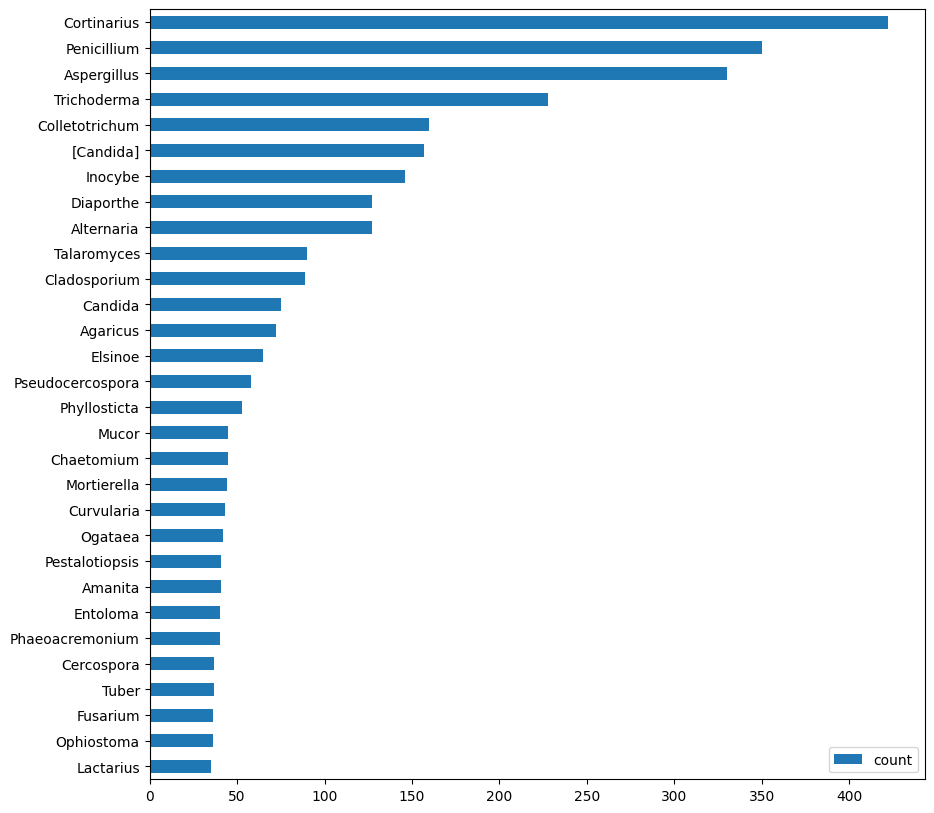

In [33]:
%matplotlib inline

import pandas as pd

most_common = count_genera.most_common(30)
names, values = zip(*reversed(most_common))

count_genera_df = pd.DataFrame(index=names, data={'count': list(values)})
count_genera_df.plot.barh(figsize=(10, 10))

del count_genera_df

In [34]:
names_of_interest = [
    "Aspergillus sojae",          # soy sauce
    "Aspergillus oryzae",         # koji (sake, makgeolli, shochu, ...)
    "Aspergillus niger",          # citric acid
    "Aspergillus nidulans",       # industrial uses
    "Aspergillus fumigatus",      # toxic
    "Aspergillus flavus",         # toxic
    "Penicillium chrysogenum",    # makes penicillin
    "Penicillium italicum",       # plant pathogen
    "Penicillium roqueforti",     # cheese making
    "Penicillium verrucosum",     # toxic
    "Saccharomyces cerevisiae",   # beer
    "Saccharomyces eubayanus",    # beer
    "Saccharomyces pastorianus",  # beer
    "Saccharomyces paradoxus",    # wild yeast
]

selected = []
for seq in seqs:
    if seq.annotations['name'] in names_of_interest:
        selected.append(seq)

assert len(selected) == len(names_of_interest)

ids_to_names = {seq.id: seq.annotations['name'] for seq in selected}
ids_to_names

{'NR_121481.1': 'Aspergillus fumigatus',
 'NR_119495.1': 'Penicillium verrucosum',
 'NR_111545.1': 'Aspergillus sojae',
 'NR_111041.1': 'Aspergillus flavus',
 'NR_111007.1': 'Saccharomyces cerevisiae',
 'NR_103621.1': 'Penicillium roqueforti',
 'NR_077145.1': 'Penicillium chrysogenum',
 'NR_133684.1': 'Aspergillus nidulans',
 'NR_111348.1': 'Aspergillus niger',
 'NR_153215.1': 'Penicillium italicum',
 'NR_138273.1': 'Saccharomyces pastorianus',
 'NR_138272.1': 'Saccharomyces paradoxus',
 'NR_137586.1': 'Saccharomyces eubayanus',
 'NR_135395.1': 'Aspergillus oryzae'}

In [35]:
### Multiple Alignment

with open("selected_fungi.fasta", "w") as fp:
    SeqIO.write(selected, fp, "fasta")

!head selected_fungi.fasta

>NR_121481.1
AACGACTCCCCAGAGCCGGAAAGTTGGTCAAACCCGGTCATTTAGAGGAAGTAAAAGTCG
TAACAAGGTTTCCGTAGGTGAACCTGCGGAAGGATCATTACCGAGTGAGGGCCCTCTGGG
TCCAACCTCCCACCCGTGTCTATCGTACCTTGTTGCTTCGGCGGGCCCGCCGTTTCGACG
GCCGCCGGGGAGGCCTTGCGCCCCCGGGCCCGCGCCCGCCGAAGACCCCAACATGAACGC
TGTTCTGAAAGTATGCAGTCTGAGTTGATTATCGTAATCAGTTAAAACTTTCAACAACGG
ATCTCTTGGTTCCGGCATCGATGAAGAACGCAGCGAAATGCGATAAGTAATGTGAATTGC
AGAATTCAGTGAATCATCGAGTCTTTGAACGCACATTGCGCCCCCTGGTATTCCGGGGGG
CATGCCTGTCCGAGCGTCATTGCTGCCCTCAAGCACGGCTTGTGTGTTGGGCCCCCGTCC
CCCTCTCCCGGGGGACGGGCCCGAAAGGCAGCGGCGGCACCGCGTCCGGTCCTCGAGCGT


In [36]:
mafft_cmd = MafftCommandline(input="selected_fungi.fasta")
stdout, stderr = mafft_cmd()

with open("selected_aligned.fasta", "w") as fp:
    fp.write(stdout)

#print(stderr)
print(stdout)

>NR_121481.1
aacgactccccagagccggaaagttggtcaaacccggtcatttagaggaagtaaaagtcg
taacaaggtttccgtaggtgaacct----------------gcggaaggatcattaccga
gtgagg-----------------gccctctgggtccaacctcccacccgtgtcta-----
-----------tcgtacctt-gttgcttcggcgggc------------------------
-------------ccgccgtttcgacggccgccggggag--g------------------
-ccttgcgcc-cccgggcccgcgcccgccgaagaccccaa--------------------
-catgaacgctgt-tctgaaagta-tgcagtctgagttgatt---atcgtaatcagttaa
aactttcaacaacggatctcttggttccggcatcgatgaagaacgcagcgaaatgcgata
agtaatgtgaattgcagaattcagtgaatcatcgagtctttgaacgcacattgcgccccc
tggtattccggggggcatgcctgtccgagcgtcattgctgccc-tcaagc----------
-------------------------------------acggcttgtgtgttgggcccccg
tccccctctcccggggg---------acgggcccgaaaggcagcggcggcaccgcgtccg
gtcctcgagcgtatggggctttgtcacctgc-----------tctgt---aggcccggcc
ggcgccagccgaca----------------cccaactttatttttctaaggttgacctcg
gatcaggtagggatacccgctgaacttaagcatatcaataagcggaggaaaagaaaccaa
cagggattgcctcagtaacggcgagtgaa-
>NR_119495.1
----------------------------

In [37]:
from io import StringIO
from Bio import AlignIO
align = AlignIO.read(StringIO(stdout), "fasta")

from IPython.display import display

def Fasta(data=''):
    bundle = {}
    bundle['application/vnd.fasta.fasta'] = data
    bundle['text/plain'] = data
    display(bundle, raw=True)

Fasta(stdout)

>NR_121481.1
aacgactccccagagccggaaagttggtcaaacccggtcatttagaggaagtaaaagtcg
taacaaggtttccgtaggtgaacct----------------gcggaaggatcattaccga
gtgagg-----------------gccctctgggtccaacctcccacccgtgtcta-----
-----------tcgtacctt-gttgcttcggcgggc------------------------
-------------ccgccgtttcgacggccgccggggag--g------------------
-ccttgcgcc-cccgggcccgcgcccgccgaagaccccaa--------------------
-catgaacgctgt-tctgaaagta-tgcagtctgagttgatt---atcgtaatcagttaa
aactttcaacaacggatctcttggttccggcatcgatgaagaacgcagcgaaatgcgata
agtaatgtgaattgcagaattcagtgaatcatcgagtctttgaacgcacattgcgccccc
tggtattccggggggcatgcctgtccgagcgtcattgctgccc-tcaagc----------
-------------------------------------acggcttgtgtgttgggcccccg
tccccctctcccggggg---------acgggcccgaaaggcagcggcggcaccgcgtccg
gtcctcgagcgtatggggctttgtcacctgc-----------tctgt---aggcccggcc
ggcgccagccgaca----------------cccaactttatttttctaaggttgacctcg
gatcaggtagggatacccgctgaacttaagcatatcaataagcggaggaaaagaaaccaa
cagggattgcctcagtaacggcgagtgaa-
>NR_119495.1
----------------------------

In [38]:
ids_to_names

{'NR_121481.1': 'Aspergillus fumigatus',
 'NR_119495.1': 'Penicillium verrucosum',
 'NR_111545.1': 'Aspergillus sojae',
 'NR_111041.1': 'Aspergillus flavus',
 'NR_111007.1': 'Saccharomyces cerevisiae',
 'NR_103621.1': 'Penicillium roqueforti',
 'NR_077145.1': 'Penicillium chrysogenum',
 'NR_133684.1': 'Aspergillus nidulans',
 'NR_111348.1': 'Aspergillus niger',
 'NR_153215.1': 'Penicillium italicum',
 'NR_138273.1': 'Saccharomyces pastorianus',
 'NR_138272.1': 'Saccharomyces paradoxus',
 'NR_137586.1': 'Saccharomyces eubayanus',
 'NR_135395.1': 'Aspergillus oryzae'}

In [39]:
### Building a phylogenetic tree

from Bio.Phylo.Applications import FastTreeCommandline
fasttree = FastTreeCommandline(
    input="selected_aligned.fasta", out="selected.newick", nt=True
)
stdout, stderr = fasttree()
!cat selected.newick

(((NR_138273.1:0.000000005,NR_137586.1:0.001367900)1.000:0.018450255,(NR_111007.1:0.003934245,NR_138272.1:0.005197272)0.034:0.000000005)1.000:0.539647310,(NR_077145.1:0.000000005,(NR_103621.1:0.020574459,(NR_119495.1:0.005003781,NR_153215.1:0.009594693)0.742:0.001600756)0.434:0.003361556)0.726:0.019236174,((NR_111348.1:0.050773365,(NR_121481.1:0.020134595,NR_133684.1:0.105585547)0.264:0.010272754)0.125:0.016901407,(NR_111545.1:0.006045015,(NR_111041.1:0.001681290,NR_135395.1:0.001593242)0.826:0.004799979)1.000:0.059609078)0.874:0.028562455);


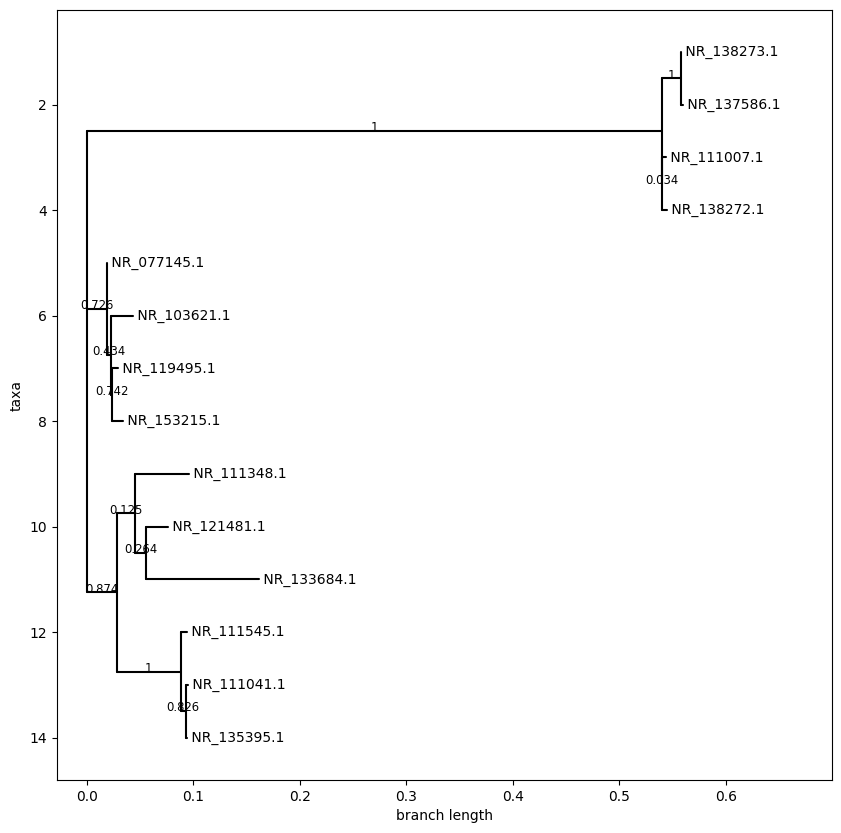

In [40]:
### Visualizing the phylogenetic tree

from Bio import Phylo

tree = Phylo.read("selected.newick", "newick")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
Phylo.draw(tree, axes=ax)

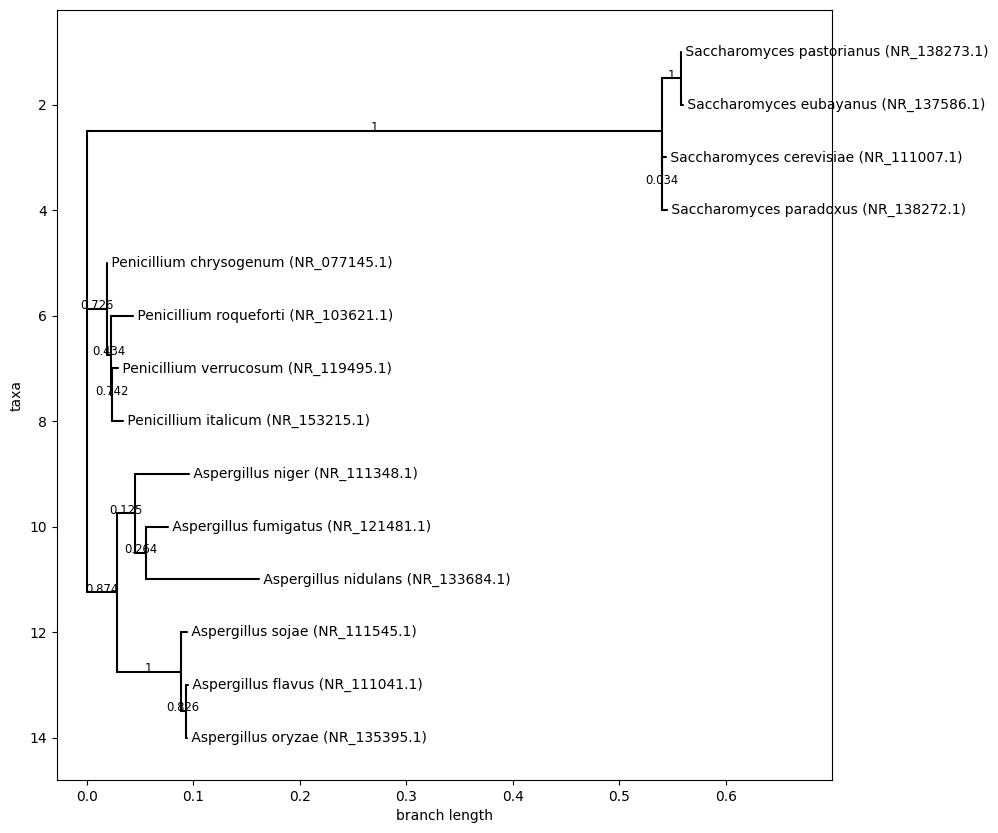

In [41]:
ids_to_names['NR_138273.1']
def id_to_name(node):
    seq_id = node.name
    name = ids_to_names.get(seq_id)
    if name is None:
        return None
    return f"{name} ({seq_id})"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
Phylo.draw(tree, axes=ax, label_func=id_to_name)

In [43]:
# Install ete3 + required dependencies
!apt-get install -y python3-pyqt5
!pip install ete3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-pyqt5 is already the newest version (5.15.6+dfsg-1ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [1]:
!apt-get install -y python3-pyqt5 xdg-utils xvfb libegl1
!pip install --upgrade --force-reinstall ete3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libegl1 is already the newest version (1.4.0-1).
python3-pyqt5 is already the newest version (5.15.6+dfsg-1ubuntu3).
xdg-utils is already the newest version (1.1.3-4.1ubuntu3~22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
  Using cached ete3-3.1.3-py3-none-any.whl
  Attempting uninstall: ete3
    Found existing installation: ete3 3.1.3
    Uninstalling ete3-3.1.3:
      Successfully uninstalled ete3-3.1.3


In [48]:
!pip install scikit-bio


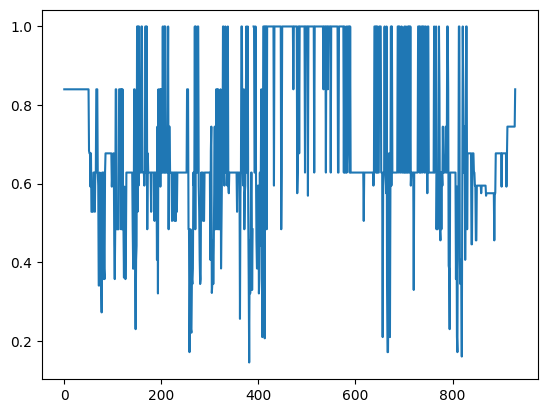

In [49]:
### Quantitative information about a multiple alignment

from skbio import TabularMSA, DNA

msa = TabularMSA.read('selected_aligned.fasta', constructor=DNA, lowercase=True)
msa.reassign_index(minter='id')
positional_conservation = msa.conservation(
    metric='inverse_shannon_uncertainty', degenerate_mode='nan', gap_mode='include'
)
plt.plot(positional_conservation)

In [50]:
from skbio import DistanceMatrix
from skbio.sequence.distance import hamming

dm = DistanceMatrix.from_iterable(msa, metric=hamming, keys=msa.index)
print(dm)

14x14 distance matrix
IDs:
'NR_121481.1', 'NR_119495.1', 'NR_111545.1', 'NR_111041.1', 'NR_111007.1', ...
Data:
[[0.         0.15483871 0.26774194 0.20860215 0.65268817 0.18924731
  0.17741935 0.26236559 0.19892473 0.2688172  0.65053763 0.63763441
  0.63978495 0.18817204]
 [0.15483871 0.         0.17096774 0.10967742 0.58817204 0.04408602
  0.03225806 0.18064516 0.12795699 0.12043011 0.58494624 0.56451613
  0.5483871  0.12473118]
 [0.26774194 0.17096774 0.         0.0827957  0.56666667 0.14516129
  0.14408602 0.1827957  0.11935484 0.14408602 0.56344086 0.54516129
  0.50430108 0.10537634]
 [0.20860215 0.10967742 0.0827957  0.         0.56989247 0.08494624
  0.08387097 0.16344086 0.10752688 0.17311828 0.56666667 0.54731183
  0.53010753 0.0688172 ]
 [0.65268817 0.58817204 0.56666667 0.56989247 0.         0.56129032
  0.56021505 0.56129032 0.54946237 0.51182796 0.02688172 0.03548387
  0.08709677 0.62258065]
 [0.18924731 0.04408602 0.14516129 0.08494624 0.56129032 0.
  0.0172043  0.15483871

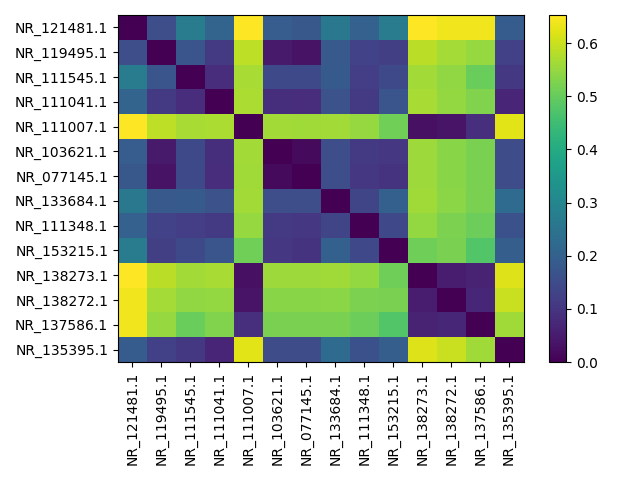

In [51]:
dm

In [52]:
### Principal coordinate analysis

import skbio
pc = skbio.stats.ordination.pcoa(dm)
pc.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
NR_121481.1,-0.234574,0.149827,0.040142,-0.020997,0.036721,0.006446,-0.003396,0.000052,-0.000165,0.0,0.0,0.0,0.0,0.0
NR_119495.1,-0.175797,0.034108,0.005451,0.035615,-0.038952,-0.000667,-0.025524,0.001356,0.000245,0.0,0.0,0.0,0.0,0.0
NR_111545.1,-0.140247,-0.104580,0.026118,-0.018435,0.025287,-0.009209,0.014781,0.002422,-0.001091,0.0,0.0,0.0,0.0,0.0
NR_111041.1,-0.156886,-0.027789,0.024431,-0.039044,-0.020691,0.014551,0.043735,-0.002580,0.000098,0.0,0.0,0.0,0.0,0.0
NR_111007.1,0.408360,0.032830,-0.003609,0.017411,0.019298,0.012904,0.016429,0.014011,0.001219,0.0,0.0,0.0,0.0,0.0
NR_103621.1,-0.148841,0.012088,-0.018895,0.026260,-0.041034,-0.008742,0.010527,-0.001811,0.007002,0.0,0.0,0.0,0.0,0.0
NR_077145.1,-0.148718,0.018427,-0.015914,0.028136,-0.031117,-0.009100,0.006587,0.001021,-0.008078,0.0,0.0,0.0,0.0,0.0
NR_133684.1,-0.131744,-0.021575,-0.125639,-0.056387,0.008560,0.032285,-0.015538,0.000056,-0.000070,0.0,0.0,0.0,0.0,0.0
NR_111348.1,-0.132679,-0.004864,-0.029901,-0.029533,0.036608,-0.053009,-0.005003,-0.001147,0.001103,0.0,0.0,0.0,0.0,0.0
NR_153215.1,-0.098081,-0.034587,-0.021972,0.113362,0.024101,0.003316,0.001923,0.000494,0.000197,0.0,0.0,0.0,0.0,0.0


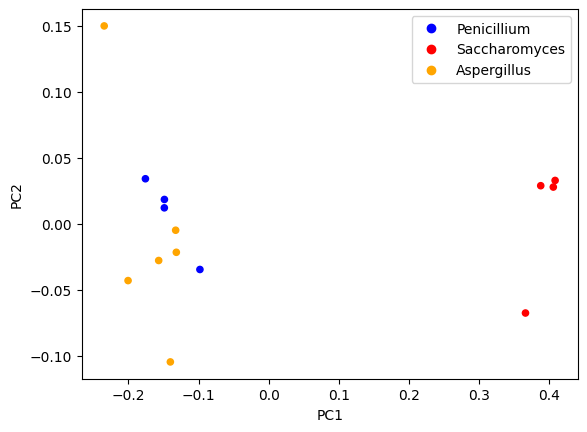

In [53]:
taxa_to_colors = {
    "Penicillium": "blue",
    "Saccharomyces": "red",
    "Aspergillus": "orange"
}
colors = [taxa_to_colors[ids_to_names[id_].split()[0]] for id_ in pc.samples.index]

pc.samples.plot.scatter(x='PC1', y='PC2', c=colors)

for genus, color in taxa_to_colors.items():
    plt.plot([], [], 'o', c=color, label=genus)
plt.legend()

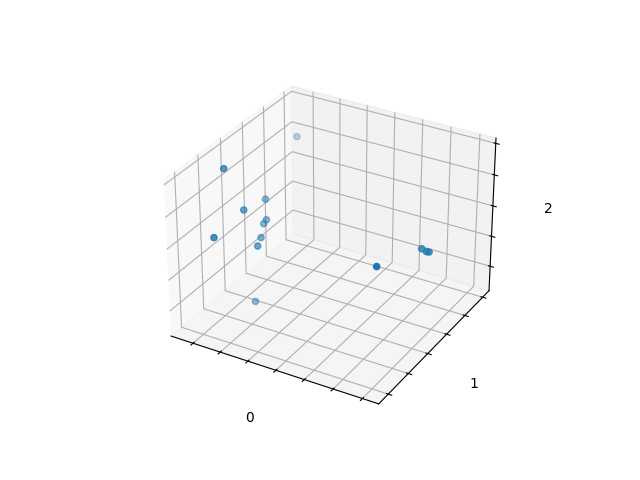

In [54]:
pc

In [55]:
from skbio.tree import nj
sk_tree = nj(dm)
print(sk_tree.ascii_art())

                    /-NR_121481.1
          /--------|
         |         |          /-NR_119495.1
         |          \--------|
         |                   |          /-NR_103621.1
         |                    \--------|
         |                              \-NR_077145.1
         |
         |                    /-NR_133684.1
         |          /--------|
         |         |          \-NR_111348.1
         |         |
---------|---------|          /-NR_153215.1
         |         |         |
         |         |         |                              /-NR_111007.1
         |          \--------|                    /--------|
         |                   |          /--------|          \-NR_138273.1
         |                   |         |         |
         |                    \--------|          \-NR_138272.1
         |                             |
         |                              \-NR_137586.1
         |
         |          /-NR_111545.1
          \--------|
          